# Conceptors Introduction

This notebook contains sample implementations for basic conceptor ideas.

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize']=(8.0,6.0)
mpl.rcParams['font.size']=14

import numpy as np

np.random.seed(1)

First we configure the network for a given size and connectivity.

In [13]:
# network size
N = 100

# network connectivity
netConn = 10./N
#netConn = 1

### Weight Matrix
The initial weight matrix is randomly generated and sparse:

In [14]:
# requires sprandn function which is not implemented in scipy
import numpy.random
import scipy.sparse

def sprandn(m, n, density):
    nnz = max(0, min(int(m*n*density), m*n))
    seq = np.random.permutation(m*n)[:nnz]
    data = np.random.randn(nnz)
    return scipy.sparse.csr_matrix((data, (seq/n,seq%n)), shape=(m,n)).todense()

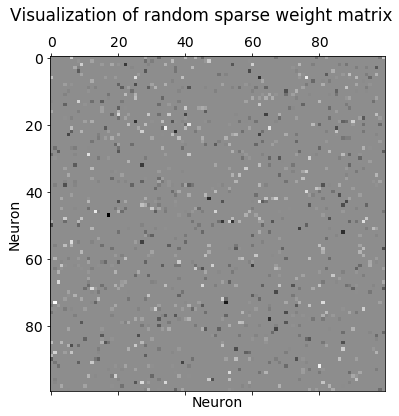

In [15]:
# initialize random weights
W_unscaled = sprandn(N,N,netConn)

plt.matshow(W_unscaled, cmap=plt.cm.gray);
plt.suptitle("Visualization of random sparse weight matrix");
plt.ylabel("Neuron");
plt.xlabel("Neuron");

Now we scale the weight matrix such that the spectral radius (i.e. the largest eigenvalue) becomes 1. Therefore we first need to compute the spectral radius and divide by it.

In [16]:
import scipy.linalg
# compute the spectral radius (= largest eigenvalue)
def getSpecRad(m):
    specRad, largestEigenvec = np.abs(scipy.linalg.eigh(m,eigvals=(N-1, N-1)))
    return specRad[0]

In [23]:
specRad = getSpecRad(W_unscaled)
print("Spectral radius of the random matrix: {}".format(specRad))

W_raw = W_unscaled/specRad * 1.5

# the new spectral radius is 1.5
print("Now the spectral radius is {}".format(getSpecRad(W_raw)))

Spectral radius of the random matrix: 6.500926796533468
Now the spectral radius is 1.4999999999999998


### Input Matrix
Now we set the input weights to the reservoir. It is also randomly initialized with certain scaling factors.

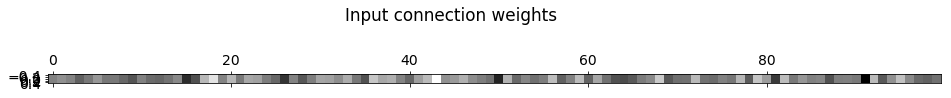

In [24]:
netInputScaling = 1.5
numInputDims = 1

W_in = netInputScaling * np.random.normal(0,1,(N,numInputDims))

plt.matshow(W_in.T, cmap=plt.cm.gray);
plt.suptitle("Input connection weights");

### Bias Matrix

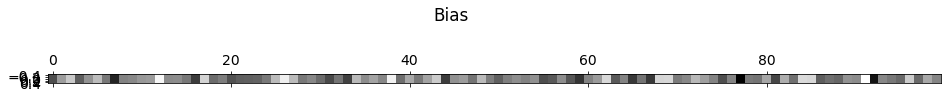

In [25]:
biasScaling = 0.2

W_bias = biasScaling * np.random.normal(0,1,(N,1))

plt.matshow(np.asmatrix(W_bias.T), cmap=plt.cm.gray);
plt.suptitle("Bias");

### Recap
We need these 3 matrices (weight, input, bias) for the computation of the update rule:

$ x(n+1) = \tanh (W x(n) + W_{in} p(n+1) + W_{bias} ) $

Where W is the weight matrix, currently our W_raw.

# Inputs
Now we need input patterns to train the network on.

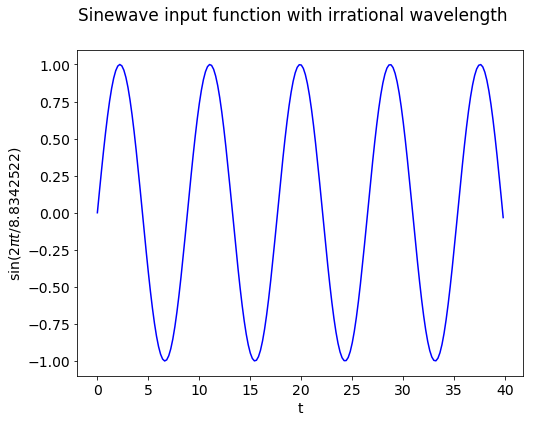

In [26]:
sinewave_1 = lambda n: np.matrix([[np.sin(2 * np.pi * n / 8.8342522)]])

x_vals = np.arange(0,40,0.2)
plt.plot(x_vals,[sinewave_1(x)[0, 0] for x in x_vals], 'b');
plt.suptitle("Sinewave input function with irrational wavelength");
plt.xlabel("t");
plt.ylabel("$\sin (2\pi t / 8.8342522)$");

# Harvesting network states

Now we let the network run and collect states from it. To get it "swinging" in the beginning, we add an additional "washout" period, during which we do not track the network.

In [28]:
washoutTimesteps = 500
learnTimesteps = 1000

# init empty state
x = np.zeros((N, 1))

stateCollector = np.zeros((N, learnTimesteps))
inputCollector = np.zeros((numInputDims, learnTimesteps))

washoutStateCollector = np.zeros((N, washoutTimesteps))

for t in range(washoutTimesteps + learnTimesteps):
    # get input from pattern-function
    u = sinewave_1(t)
    
    # update rule
    x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)
    
    # if we are over the washout period, we start saving states
    if t >= washoutTimesteps:
        # we need to transpose x and u,
        # because accessing a row OR column in a numpy matrix always resturns a row vector
        stateCollector[:, t - washoutTimesteps] = x.T
        inputCollector[:, t - washoutTimesteps] = u.T
    
    # save washout state sequence as well for inspection
    else:
        washoutStateCollector[:, t] = x.T

In [ ]:
### Visualize harvest

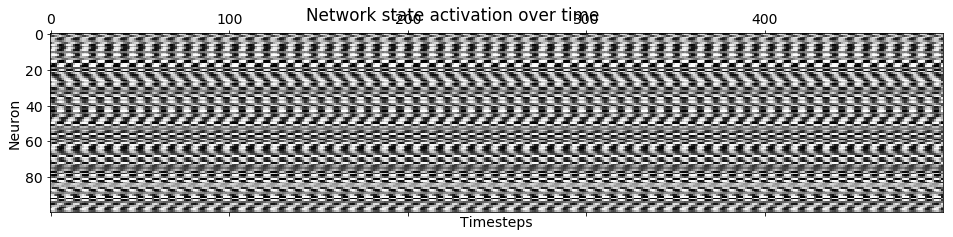

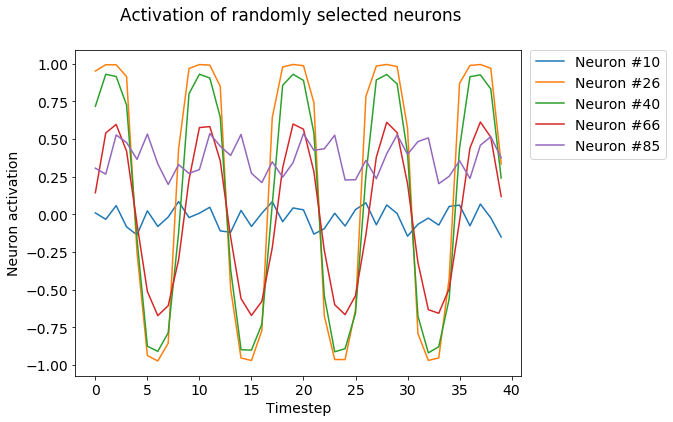

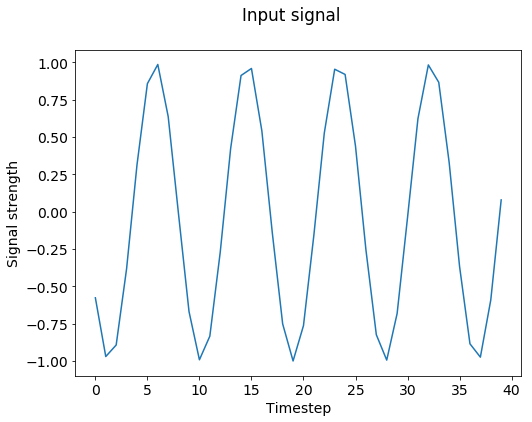

In [29]:
# show the states over time
plt.matshow(stateCollector[:,0:500], cmap=plt.cm.gray);
plt.suptitle("Network state activation over time");
plt.xlabel("Timesteps");
plt.ylabel("Neuron");

# plot 5 randomly selected neurons
plt.figure();
neuron_idxs = np.random.permutation(range(N))[0:5]
neuron_idxs.sort()
for i, neuron in enumerate(neuron_idxs):
    plt.plot(stateCollector[neuron ,0:40], label="Neuron #{}".format(neuron));
plt.suptitle("Activation of randomly selected neurons");
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.xlabel("Timestep");
plt.ylabel("Neuron activation");

    
# plot input
plt.figure();
plt.plot(inputCollector[0,0:40]);
plt.suptitle("Input signal");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");

## Train output weights
Train W_out such that it linearly combines the state activation to recreate the input sequence. For this we use the Tikhonov regularization (Ridge regression).

### Tikhonov regularization
The idea is to solve the equation $Ax=b$ for x under the constraint that the norm of $x$ stays small. This minimizes both the error $||Ax-b||^2$ and a regularization term $||\alpha I||^2$ where $\alpha$ is a factor of how much big weights are penalized.

So $||Ax-b||^2 + ||\alpha I||^2$ will be minimized.

An explicit solution is $\hat{x} = (A^T A + (\alpha I)^T (\alpha I))^{-1} A^T b$

In [30]:
def ridgeRegression(A, b, alpha):
    aI = alpha * np.eye(A.shape[1])
    first = np.linalg.inv(np.dot(A.T, A) + np.dot(aI.T, aI))
    return np.dot(first , np.dot(A.T, b))

Now we have to plug in our values. Since for every state we want to generate the actual input as output of the network, for every timestep it holds:

$state * W_{out} = input$

So when we calculate $W_{out}$ we want it to work for every timestep, so we solve

$stateSequence * W_{out} = inputSequence$

for $W_{out}$.

In [31]:
# we need to transpose out data to fit into the equation
W_out = ridgeRegression(
    A = stateCollector.T,
    b = inputCollector.T,
    alpha = 0.01)

## Test trained output matrix
Now we just append this phase after the washout+learning phase, such that the states that we test on are not the same we learned on.

In [33]:
testTimesteps = 200

# continue with last state
x = x

testOutputCollector = np.zeros((numInputDims, testTimesteps))
testInputCollector = np.zeros((numInputDims, testTimesteps))


for t in range(testTimesteps):
    # get input from pattern-function after washout and learning phase
    # this means we just continue after this phase
    u = sinewave_1(washoutTimesteps + learnTimesteps + t)
    
    # update rule
    x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)
    
    # start computing outputs
    output = np.dot(x.T, W_out)
    testOutputCollector[:, t] = output.T
    testInputCollector[:, t] = u.T

### Plot output from trained output matrix vs input

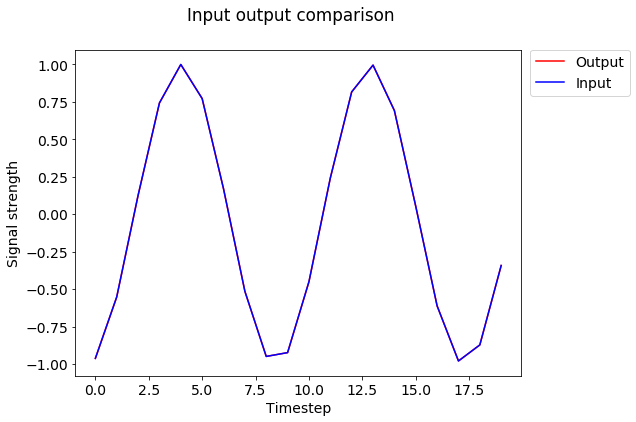

In [34]:
plt.plot(testOutputCollector[0,0:20], 'r', label="Output");
plt.plot(testInputCollector[0,0:20], 'b', label="Input");
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.suptitle("Input output comparison");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");

### Error measure
We use the NRMSE as defined by Wikipedia:

$$NRMSE = \frac{RMSE}{y_{max}-y_{min}}$$ where $$RMSE = \sqrt{\frac{1}{n}\sum (\hat{y}-y)^2}$$

In [36]:
def NRMSE(output, target):
    error = target - output
    
    # ptp = range
    peakToPeak = np.ptp(target, axis=1)
    rmse = np.sqrt(np.mean(error**2, axis=1))
    nrmse = rmse / peakToPeak
    return nrmse

print('NRMSE Readout: {}'.format(NRMSE(testOutputCollector, testInputCollector)))

NRMSE Readout: [  1.11944281e-05]


# Loading
Now we load the weight matrix. This means that the weight matrix is itself capable of producing the pattern in absence of an input to the network.

Again we do a ridge regression. We want to find a new weight matrix W such that applying W to a state produces the activation that was previously produced from BOTH state- AND input-activation. So for every timestep it should hold:

$$ x(n) \cdot W_{new} = W_{old}\cdot x(n) + W_{in}\cdot u(n)$$

With the regression we fit $W_{new}$ to otimize this for all timesteps. The target for the regression is therefore

$$W_{old}\cdot x(n) + W_{in}\cdot u(n)$$

To calculate it, we rearrange the update rule:

$$ x(n+1) = \tanh (W x(n) + W_{in} p(n+1) + W_{bias} ) $$

$$W_{old}\cdot x(n) + W_{in}\cdot u(n) = \tanh^{-1} (x(n+1)) - W_{bias}$$

Now leaving away the input will still produce the same results just from letting the network run on its own.

Spec Rad of the loaded weight matrix 4.72093555562
mean NRMSE W: 0.00818645323786


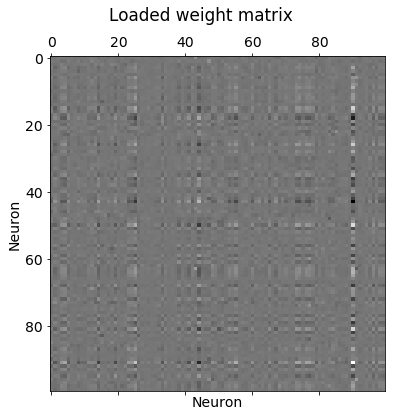

In [38]:
stateCollectorOld = np.zeros((N, learnTimesteps))
stateCollectorOld[:,1:] = stateCollector[:,0:-1]

target = np.arctanh(stateCollector) - np.tile(W_bias, (1, learnTimesteps))

W_loaded = ridgeRegression(stateCollectorOld.T, target.T, 0.1).T

# Herberts regression
#xxT = np.dot(stateCollectorOld, stateCollectorOld.T) 
#W_loaded = np.dot(np.dot(np.linalg.inv(xxT +  0.01 * np.eye(N)), stateCollectorOld), target.T).T

loadSpecRad = getSpecRad(W_loaded)
print('Spec Rad of the loaded weight matrix ' + str(loadSpecRad))

# training error per neuron
nrmse_loading = NRMSE(np.dot(W_loaded, stateCollectorOld), target)
print('mean NRMSE W: ' + str(np.mean(nrmse_loading)))


plt.matshow(W_loaded, cmap=plt.cm.gray);
plt.suptitle("Loaded weight matrix");
plt.xlabel("Neuron");
plt.ylabel("Neuron");

### Conceptor
We now build a filter for the state space that acts as a regularized identity mapping on the netowork activations under the current pattern. We will call this filter "Conceptor" of that pattern. The Conceptor optimises the compromise between not altering the network states (identity mapping) and at the same time having low weights (i.e being sparse: suppressing umimportant directions in the state space)

In order to calculate the Conceptor Matrix we first compute the Covariance Matrix of the States the Neurons went through during the course of the learning phase. We then perform Singular Value Decomposition and then modify the Eigenvalues according to: 




$S_{new} = S \cdot (S+\alpha^{-2}I)^{-1})$

Consequences:

* Values in S_new are < 1
* The bigger $\alpha$, the smaller the values in S_new.
* The bigger the previous value in S, the bigger the value in S_new will be.

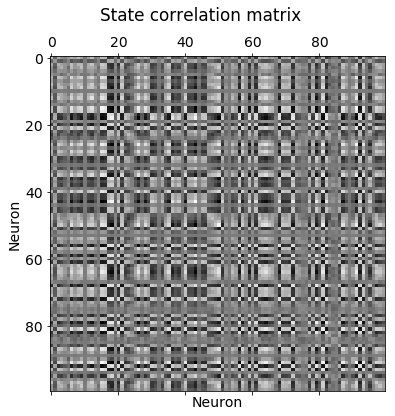

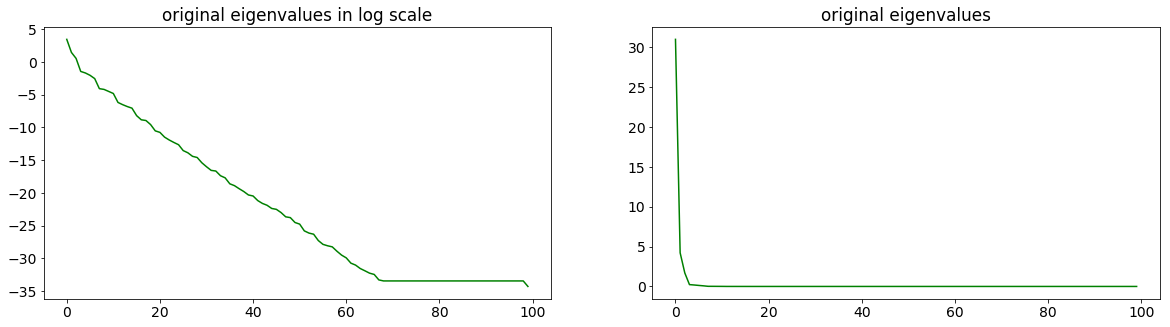

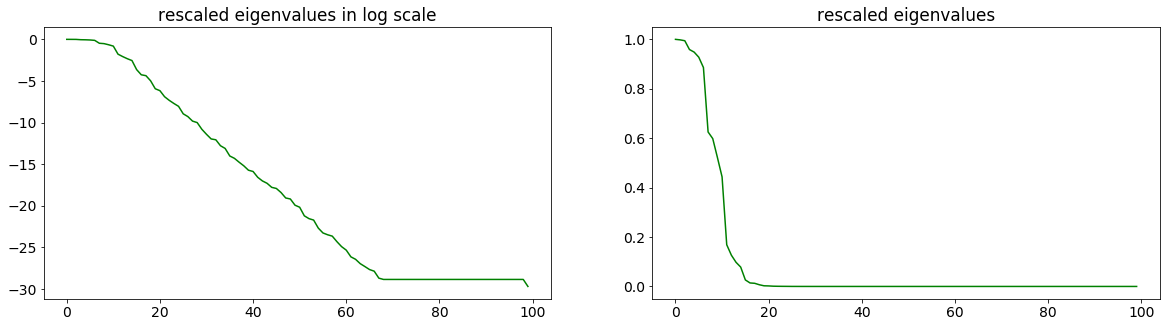

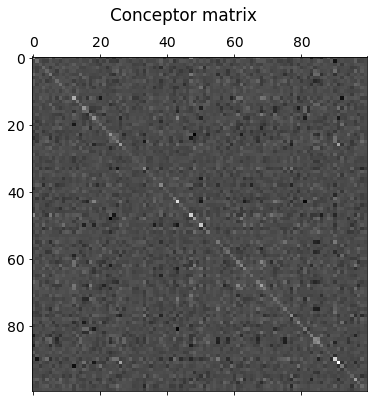

In [39]:
I = np.eye(N)

# Aperture alpha
alpha = 10

# State correlation matrix
R = np.dot(stateCollector, stateCollector.T) / learnTimesteps
plt.matshow(R, cmap=plt.cm.gray);
plt.suptitle("State correlation matrix");
plt.xlabel("Neuron");
plt.ylabel("Neuron");

# What other matrices could we use? Covariance matrix? Cross-correlation matrix?

U,S,V = np.linalg.svd(R, full_matrices=True) 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1).set_title("original eigenvalues in log scale")
plt.plot(np.log(S), 'g')
plt.subplot(1,2,2).set_title("original eigenvalues")
plt.plot(S, 'g')

S = np.diag(S)    

Snew = (np.dot(S,np.linalg.inv(S + (alpha**-2)*I)))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1).set_title("rescaled eigenvalues in log scale")
plt.plot(np.log(np.diagonal(Snew)), 'g')
plt.subplot(1,2,2).set_title("rescaled eigenvalues")
plt.plot(np.diagonal(Snew), 'g')

# svd backwards with new S
C = np.dot(U,np.dot(Snew,V))

plt.matshow(C, cmap=plt.cm.gray);
plt.suptitle("Conceptor matrix");

### Test the loading
Now when we let the network run on its own, it should produce the signal again.

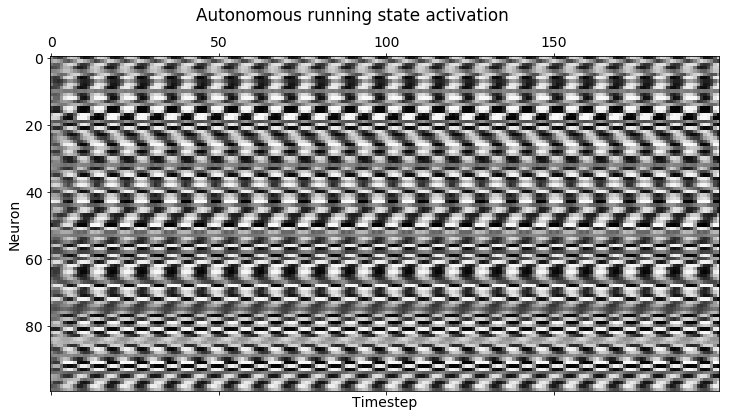

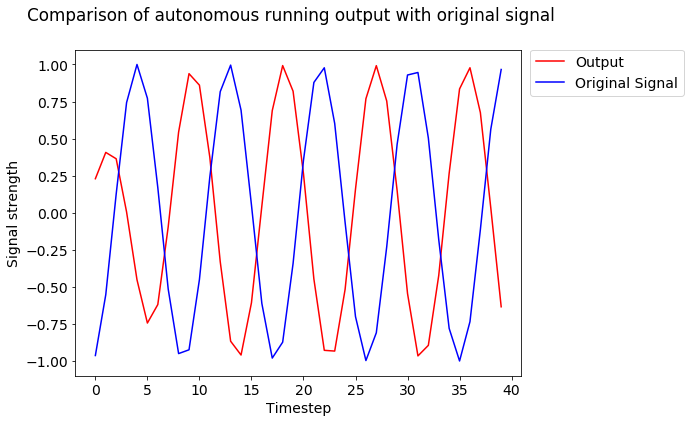

In [41]:
loadingTestTimesteps = 200

# init random state
x = 0.5*np.random.randn(N, 1)

loadingTestOutputCollector = np.zeros((numInputDims, loadingTestTimesteps))
loadingTestStateCollector = np.zeros((N, loadingTestTimesteps))

for t in range(loadingTestTimesteps):
    
    # update rule
    x = np.tanh(np.dot(W_loaded, x) + W_bias)
    
    # Apply the Concepor
    x = np.dot(C,x)
    
    loadingTestStateCollector[:, t] = x.T
    
    output = np.dot(x.T, W_out)
    loadingTestOutputCollector[:, t] = output.T



plt.matshow(loadingTestStateCollector[:,:], cmap=plt.cm.gray);
plt.suptitle("Autonomous running state activation");
plt.xlabel("Timestep");
plt.ylabel("Neuron");

plt.figure();
plt.plot(loadingTestOutputCollector[0,:40], 'r', label="Output");
plt.plot(testInputCollector[0,:40], 'b', label="Original Signal")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.suptitle("Comparison of autonomous running output with original signal");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");

### Compute NRMSE of test phase

In order to compute this NRMSE we move the two signals along each other and get rid of the inevitable phase shift that influences the NRMSE. We also perform some interpolaion to smooth sharp edges which are due to our low sampling frequency. This code is not important to understand the basic conceptor and network algorihm. 

Position of best phase match: 62
Value of Frobenius Norm of differences between patterns with best phase match: 0.256716959327


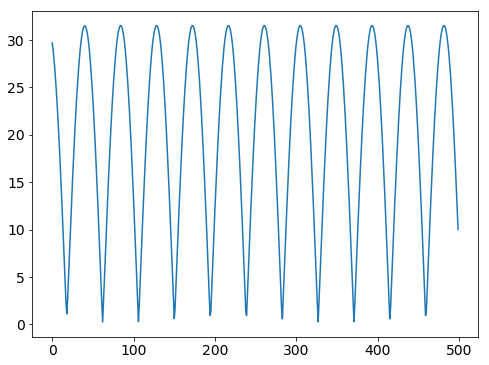

In [43]:
from scipy import interpolate

# Plotting Input I and Output Y over plotTimesteps
plotTimesteps = 100
overSamplingFactor = 5

I = inputCollector[:,0:plotTimesteps]
Y = loadingTestOutputCollector  
   
fI = interpolate.interp1d(range(plotTimesteps),I,kind='cubic') 
fY = interpolate.interp1d(range(len(Y.T)),Y,kind='cubic') 

oversampledI = np.zeros((plotTimesteps-1)*overSamplingFactor)
oversampledY = np.zeros((len(Y.T)-1)*overSamplingFactor)

for i in range(len(oversampledI)):
    oversampledI[i] = fI(i/overSamplingFactor) 
for i in range(len(oversampledY)):    
    oversampledY[i] = fY(i/overSamplingFactor) 
L = len(oversampledY)
M = len(oversampledI)

#print L
#print M

phasematches = np.zeros(L-M)   
for s in range(L-M):
    phasematches[s] = np.linalg.norm(oversampledI-oversampledY[s:s+M])
pos = np.argmin(phasematches)  
print('Position of best phase match: ' + str(pos))
val = phasematches[pos]
print('Value of Frobenius Norm of differences between patterns with best phase match: ' + str(val))
plt.plot(phasematches);

NRMSE: [ 0.00581043]


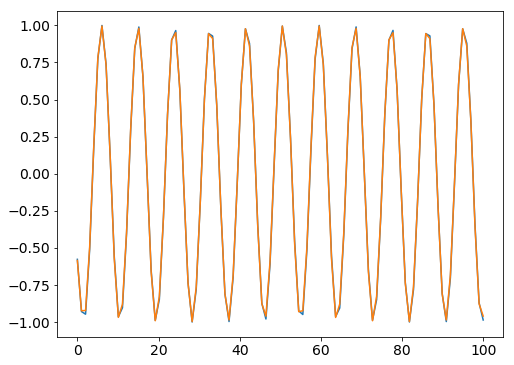

In [44]:
# aligned Y for plotting
Yidx = np.linspace(pos,pos+overSamplingFactor*(plotTimesteps-1)-1,plotTimesteps).astype(int)
Y_PL = oversampledY[Yidx]

#
Iidx = np.linspace(0,overSamplingFactor*(plotTimesteps-1)-1,plotTimesteps).astype(int)
I_PL = oversampledI[Iidx]

NRMSEsAlign = NRMSE(np.reshape(Y_PL,(1,len(Y_PL))),np.reshape(I_PL,(1,len(I_PL))))        
print('NRMSE: ' + str(NRMSEsAlign))
xspace = np.linspace(0,plotTimesteps,plotTimesteps)
plt.plot(xspace,I_PL);
plt.plot(xspace,Y_PL);